## <a id=99>Описание датасета</a>

[К датасету](#1)


---

## <center><a id=0 style='color:red'>Импорт библиотек</a>


In [1]:
import pandas as pd
from scipy.stats import kstest, kruskal
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Any, Dict
import joblib
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    StratifiedGroupKFold,
    StratifiedKFold,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
)
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    QuantileTransformer,
    Normalizer,
    MinMaxScaler,
    PowerTransformer,
    PolynomialFeatures,
    OrdinalEncoder,
    TargetEncoder,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    IsolationForest,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


from ds_nms import data_proc, utils_io, model_tune, model_tune_params, model_train, stat_tests

In [2]:
np.set_printoptions(suppress=True, precision=2)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

---

## <center><a id=1 style='color:red'>Импорт датасета</a>

[К описанию](#99)


In [3]:
df = pd.read_excel(io='data/Data_ts.xlsx', header=2)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

df.index.freq = 'MS'
display(df.head(3))
df.shape

,year,month,val_metro,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,,
2016-01-01,2016,1,7687405,0.664580,1.122006e+06,12179000,0.919547,0.0482,0.0723,1.050002e+06
2016-02-01,2016,2,7928317,0.645410,1.168815e+06,12179000,0.957532,0.0482,0.0723,9.911876e+05
2016-03-01,2016,3,8228019,0.643148,1.214508e+06,12179000,0.982312,0.0482,0.0723,1.128213e+06


(106, 10)

In [4]:
df_pred = pd.read_excel(io='data/Data_9.1.xlsx', header=2)
df_pred['date'] = pd.to_datetime(df_pred[['year', 'month']].assign(day=1))
df_pred.set_index('date', inplace=True)

df_pred.index.freq = 'MS'
display(df_pred.head(3))
df_pred.shape

,year,month,val_metro,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,,
2024-11-01,2024,11,NaN,0.645995,1.750632e+06,13150000,1.019619,0.0645,0.1828,2.263888e+06
2024-12-01,2024,12,NaN,0.640792,1.829924e+06,13150000,1.031504,0.0645,0.1828,2.344510e+06
2025-01-01,2025,1,NaN,0.658882,1.670500e+06,13150000,0.919547,0.0645,0.1828,2.541762e+06


(134, 10)

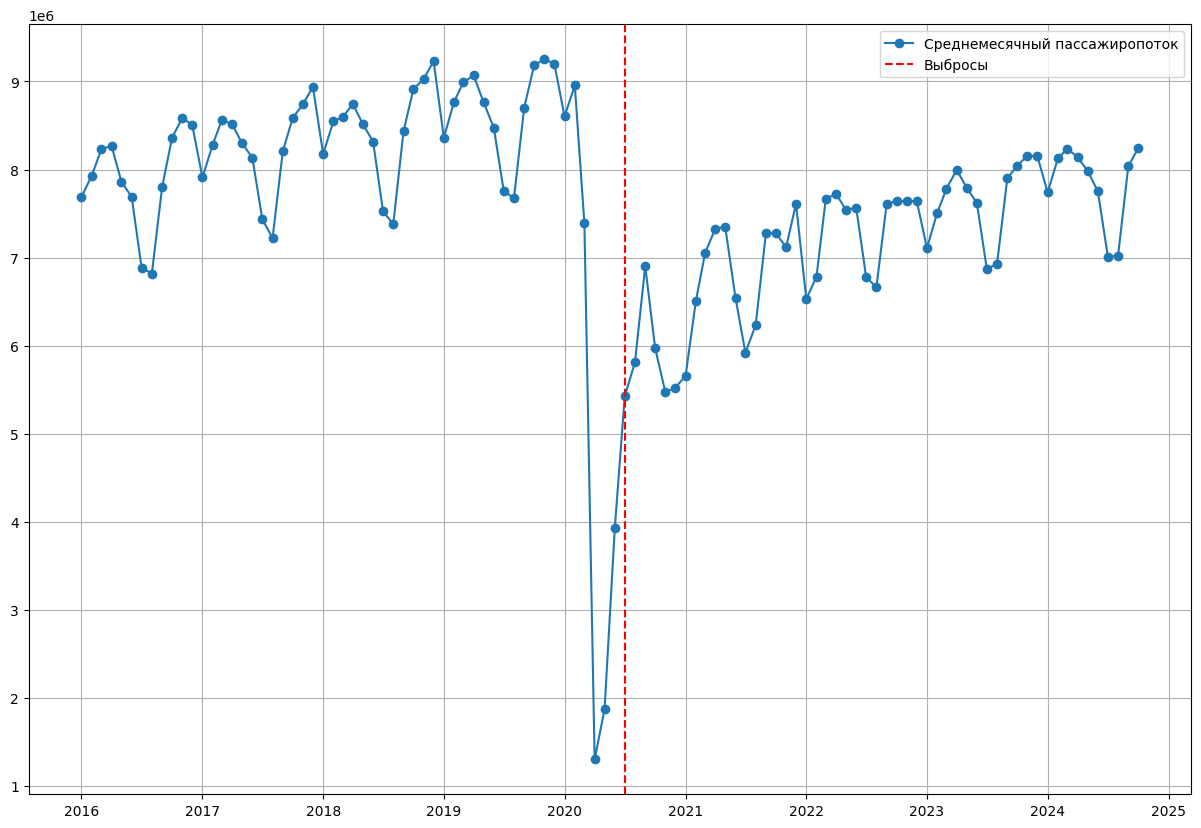

In [5]:
plt.figure(figsize=(15,10))
plt.plot(df.index, df['val_metro'], label='Среднемесячный пассажиропоток', marker='o')
plt.axvline(x=df.index[54],linestyle='--', color='r', label="Выбросы")
plt.legend()
plt.grid()

---

## <center><a id=3 style='color:red'>Разделение на обучающую и тестовую выборки</a>


In [6]:
y_train = df['val_metro']

X_train = df.drop(columns=['val_metro'])
X_pred = df_pred.drop(columns=['val_metro'])

X_train.shape, y_train.shape, X_pred.shape,

((106, 9), (106,), (134, 9))

---

## <center><a id=2 style='color:red'>Разделение на категориальные и числовые признаки</a>


In [7]:
categorical_columns, numerical_columns = data_proc.features_separate(df=df, threshold=0)
numerical_columns.remove("val_metro")

print(f"Категориальные признаки: {categorical_columns}")
print(f"Числовые признаки: {numerical_columns}")

Категориальные признаки: []
Числовые признаки: ['year', 'month', '%_ot', 'n_taxi_сar', 'p_rosstat', 'k', 'remote_work', 'hybrid', 'tourism']


---

## <center><a id=3 style='color:red'>Преобразование числовых признаков</a>


In [8]:
display(X_train.sample(1))
display(X_pred.sample(1))

,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,
2018-04-01,2018,4,0.657887,1.231768e+06,12506000,0.987336,0.0482,0.0723,1.922346e+06


,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
date,,,,,,,,,
2034-11-01,2034,11,0.695995,1.750632e+06,13150000,1.019619,0.0645,0.1828,5.379661e+06


___

### <a id=5>Стандартизация Train и Pred</a>


In [9]:
X_train_std_1, X_pred_std_1, scaler = data_proc.df_scaling(
    X_train, X_pred, numerical_columns=numerical_columns,
    scaler=StandardScaler(),
    return_scaler=True
)

joblib.dump(scaler, 'data/scalers/scaler_Data_ts_std')

,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0
mean,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.5,-1.6,-5.2,-2.6,-1.5,-2.0,-0.5,-1.0,-2.8
25%,-0.8,-0.9,-0.2,-1.0,-0.5,-0.4,-0.5,-1.0,-0.7
50%,0.0,-0.1,0.3,0.1,-0.1,0.1,-0.4,0.5,0.2
75%,0.8,0.8,0.6,1.0,1.0,0.6,0.5,1.3,0.6
max,1.6,1.6,1.3,1.7,1.4,1.4,6.1,1.3,2.0


,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0
mean,3.9,0.0,1.2,0.9,1.4,0.0,-0.4,0.5,4.2
std,1.3,1.0,0.4,0.2,0.0,1.0,0.0,0.0,1.7
min,1.6,-1.6,-0.0,0.7,1.4,-2.0,-0.4,0.5,0.9
25%,2.8,-0.7,0.8,0.8,1.4,-0.3,-0.4,0.5,2.8
50%,4.0,0.2,1.3,1.0,1.4,0.1,-0.4,0.5,4.5
75%,5.1,1.1,1.5,1.0,1.4,0.9,-0.4,0.5,5.6
max,5.9,1.6,1.7,1.3,1.4,1.4,-0.4,0.5,7.4


['data/scalers/scaler_Data_ts_std']

___

## <center><a id=3 style='color:red'>Разделение на обучающую и тестовую выборки</a>

In [10]:
X_train_test = X_train[X_train.index.year != 2024]
X_test = X_train[X_train.index.year == 2024]

y_train_test = y_train[y_train.index.year != 2024]
y_test = y_train[y_train.index.year == 2024]

X_train_test.shape, y_train_test.shape, X_test.shape, y_test.shape

((96, 9), (96,), (10, 9), (10,))

___

### <a id=5>Стандартизация Train и Test</a>

In [11]:
X_train_test_std_1, X_test_std_1, scaler = data_proc.df_scaling(
    X_train_test, X_test, numerical_columns=numerical_columns,
    scaler=StandardScaler(),
    return_scaler=True
)

X_train_test_std_1.shape, X_test_std_1.shape

,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0
mean,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.5,-1.6,-5.0,-2.5,-1.4,-2.0,-0.5,-0.9,-2.6
25%,-0.8,-0.8,-0.2,-0.9,-0.6,-0.3,-0.5,-0.9,-0.7
50%,0.0,0.0,0.3,-0.6,0.0,0.1,-0.5,-0.9,0.1
75%,0.8,0.8,0.5,1.0,0.5,0.7,0.5,1.3,0.6
max,1.5,1.6,1.3,1.8,1.6,1.3,5.8,1.3,2.0


,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
mean,2.0,-0.3,0.4,1.0,1.7,-0.2,-0.4,0.5,0.8
std,0.0,0.9,0.3,0.2,0.0,1.0,0.0,0.0,0.2
min,2.0,-1.6,-0.2,0.8,1.7,-2.0,-0.4,0.5,0.5
25%,2.0,-0.9,0.3,0.8,1.7,-0.5,-0.4,0.5,0.6
50%,2.0,-0.3,0.5,1.0,1.7,-0.0,-0.4,0.5,0.7
75%,2.0,0.4,0.6,1.1,1.7,0.4,-0.4,0.5,0.9
max,2.0,1.0,0.7,1.3,1.7,0.8,-0.4,0.5,1.1


((96, 9), (10, 9))

___

## <center><a id=3 style='color:red'>Параметры временного ряда</a>

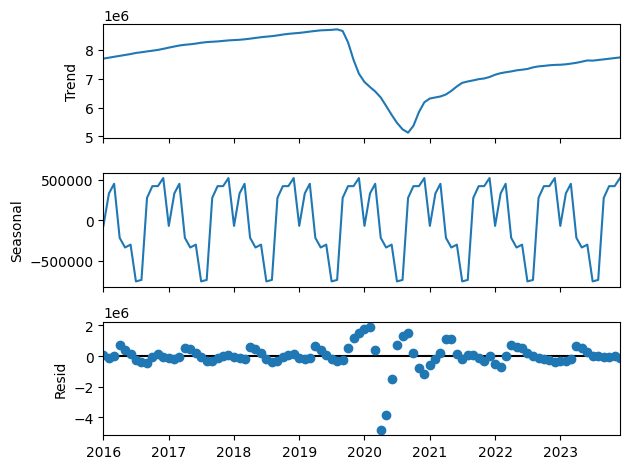

In [12]:
decomposition = seasonal_decompose(
    y_train_test,
    model="additive",
    period=12,
    extrapolate_trend="freq",  # Экстраполяция тренда для начала и конца временного ряда
)
dec = decomposition.plot(observed=False)

- Trend: сглаженное изменение уровня ряда
- Seasonal: повторяющиеся колебания
- Resid: случайные колебания, которые не объясняются трендом и сезонностью

Autocorrelation:
          - Быстро убывает после 1-2 лагов : Ряд стационарен
          - Периодические пики: присутствует сезонность
          - Резко обрывается после q-го лага: наличие скользящего среднего (MA) порядка q.
Partial Autocorrelation:
          - Резко обрывается после p-го лага : Ряд соответствует AR(p) (авторегрессия)
          - Периодические пики: присутствует сезонность
          - быстро обрывается, но ACF убывает постепенно: Указывает на ARIMA(p,d,0) модель.


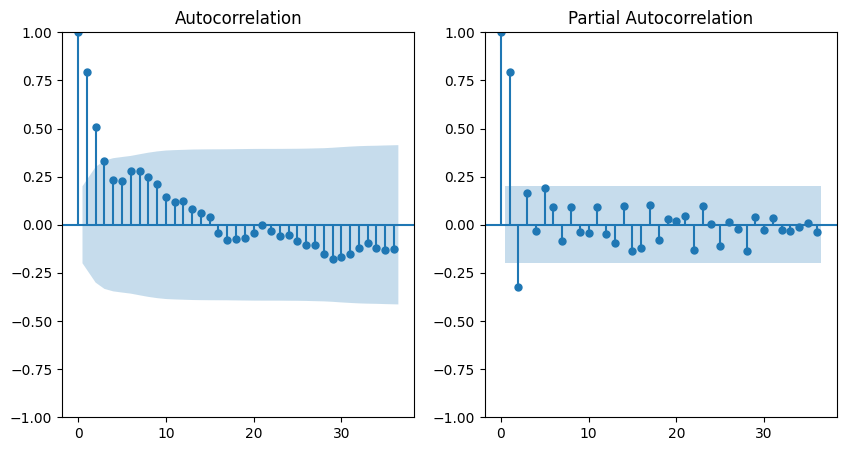

In [13]:
stat_tests.acf_pacf_plot(y=y_train_test, alpha=0.05, lags=36)

___

## <center><a id=3 style='color:red'>Тесты на стационарность ряда</a>

In [14]:
adf_result = stat_tests.stationarity_test(
    y=y_train_test,
    regression='c')

ADF: p-value=0.01559
ADF: Гипотеза о нестационарности отвергается, ряд стационарный
KPSS: p-value=0.08032
KPSS: Гипотеза о стационарности подтверждается, ряд стационарный
Ряд стационарен
ряд тренд-стационарный. Для стационарности удалить тренд


___

## <center><a id=3 style='color:red'>Обучение Lasso</a>

In [15]:
params = model_tune_params.ModelsParams()
params.set_param(model_params=params.lasso,
                 param_name="alpha",
                 args=[30000, 50000])
op_results = model_tune.get_optimize_results(
    X_train=X_train_test_std_1,
    y_train=y_train_test,
    X_test=X_test_std_1,
    y_test=y_test,
    cv_type='ts',
    train_size=24,
    val_size=12,
    n_trials=100,
    threshold=0.11,
    model_cls=Lasso,
    model_params=params.lasso
    )

Ключи для получения результатов: ['model', 'study', 'cv_metrics', 'train_metrics', 'test_metrics', 'all_metrics', 'pred_df']


In [16]:
display(op_results['cv_metrics'])
display(op_results['train_metrics'])
display(op_results['test_metrics'])

,model,data_name,R2_train_macro,R2_train_std,R2_train_splits,RMSE_train_macro,RMSE_train_std,RMSE_train_splits,NRMSE_train_macro,NRMSE_train_std,NRMSE_train_splits,MAE_train_macro,MAE_train_std,MAE_train_splits,RE_train_macro,RE_train_std,RE_train_splits,negative_train_macro,negative_train_std,negative_train_splits,R2_val_macro,R2_val_std,R2_val_splits,RMSE_val_macro,RMSE_val_std,RMSE_val_splits,NRMSE_val_macro,NRMSE_val_std,NRMSE_val_splits,MAE_val_macro,MAE_val_std,MAE_val_splits,RE_val_macro,RE_val_std,RE_val_splits,negative_val_macro,negative_val_std,negative_val_splits,R2_val_micro,RMSE_val_micro,MAE_val_micro,RE_val_micro,Negative_micro,NRMSE_val_micro,R2_diff_rel,RMSE_diff_rel,MAE_diff_rel
0,Lasso(alpha=49996.244983565164),None,0.941,0.037,"[[0.876], [0.91], [0.942], [0.977], [0.973], [...",209260.233,42653.652,"[[192477.222], [171580.179], [144170.695], [23...",0.053,0.023,"[[0.091], [0.071], [0.059], [0.03], [0.031], [...",170817.699,31925.431,"[[175673.083], [144262.697], [114038.472], [19...",1.0,0.0,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]",0.0,0.0,"[[0], [0], [0], [0], [0], [0]]",-0.038,0.923,"[[0.436], [0.674], [-1.948], [0.802], [-0.191]...",958036.764,1299498.646,"[[398075.104], [291332.594], [3858639.772], [2...",0.299,0.131,"[[0.215], [0.184], [0.504], [0.138], [0.41], [...",808459.365,1043798.393,"[[390024.083], [280739.561], [3136063.931], [2...",0.903,0.217,"[[1.0], [1.0], [0.417], [1.0], [1.0], [1.0]]",0.0,0.0,"[[0], [0], [0], [0], [0], [0]]",-0.225528,1.614476e+06,808459.364816,0.902778,0,0.203123,1.039497,3.578207,3.732878


,model_train,negative_train,RE_train,MAE_train,RMSE_train,NRMSE_train,R2_train,data
0,Lasso(alpha=49996.244983565164),0,1.0,225681.680344,275286.83191,0.034635,0.956617,None


,model_test,negative_test,RE_test,MAE_test,RMSE_test,NRMSE_test,R2_test,data
0,Lasso(alpha=49996.244983565164),0,1.0,127620.901579,143729.997474,0.11689,0.892393,None


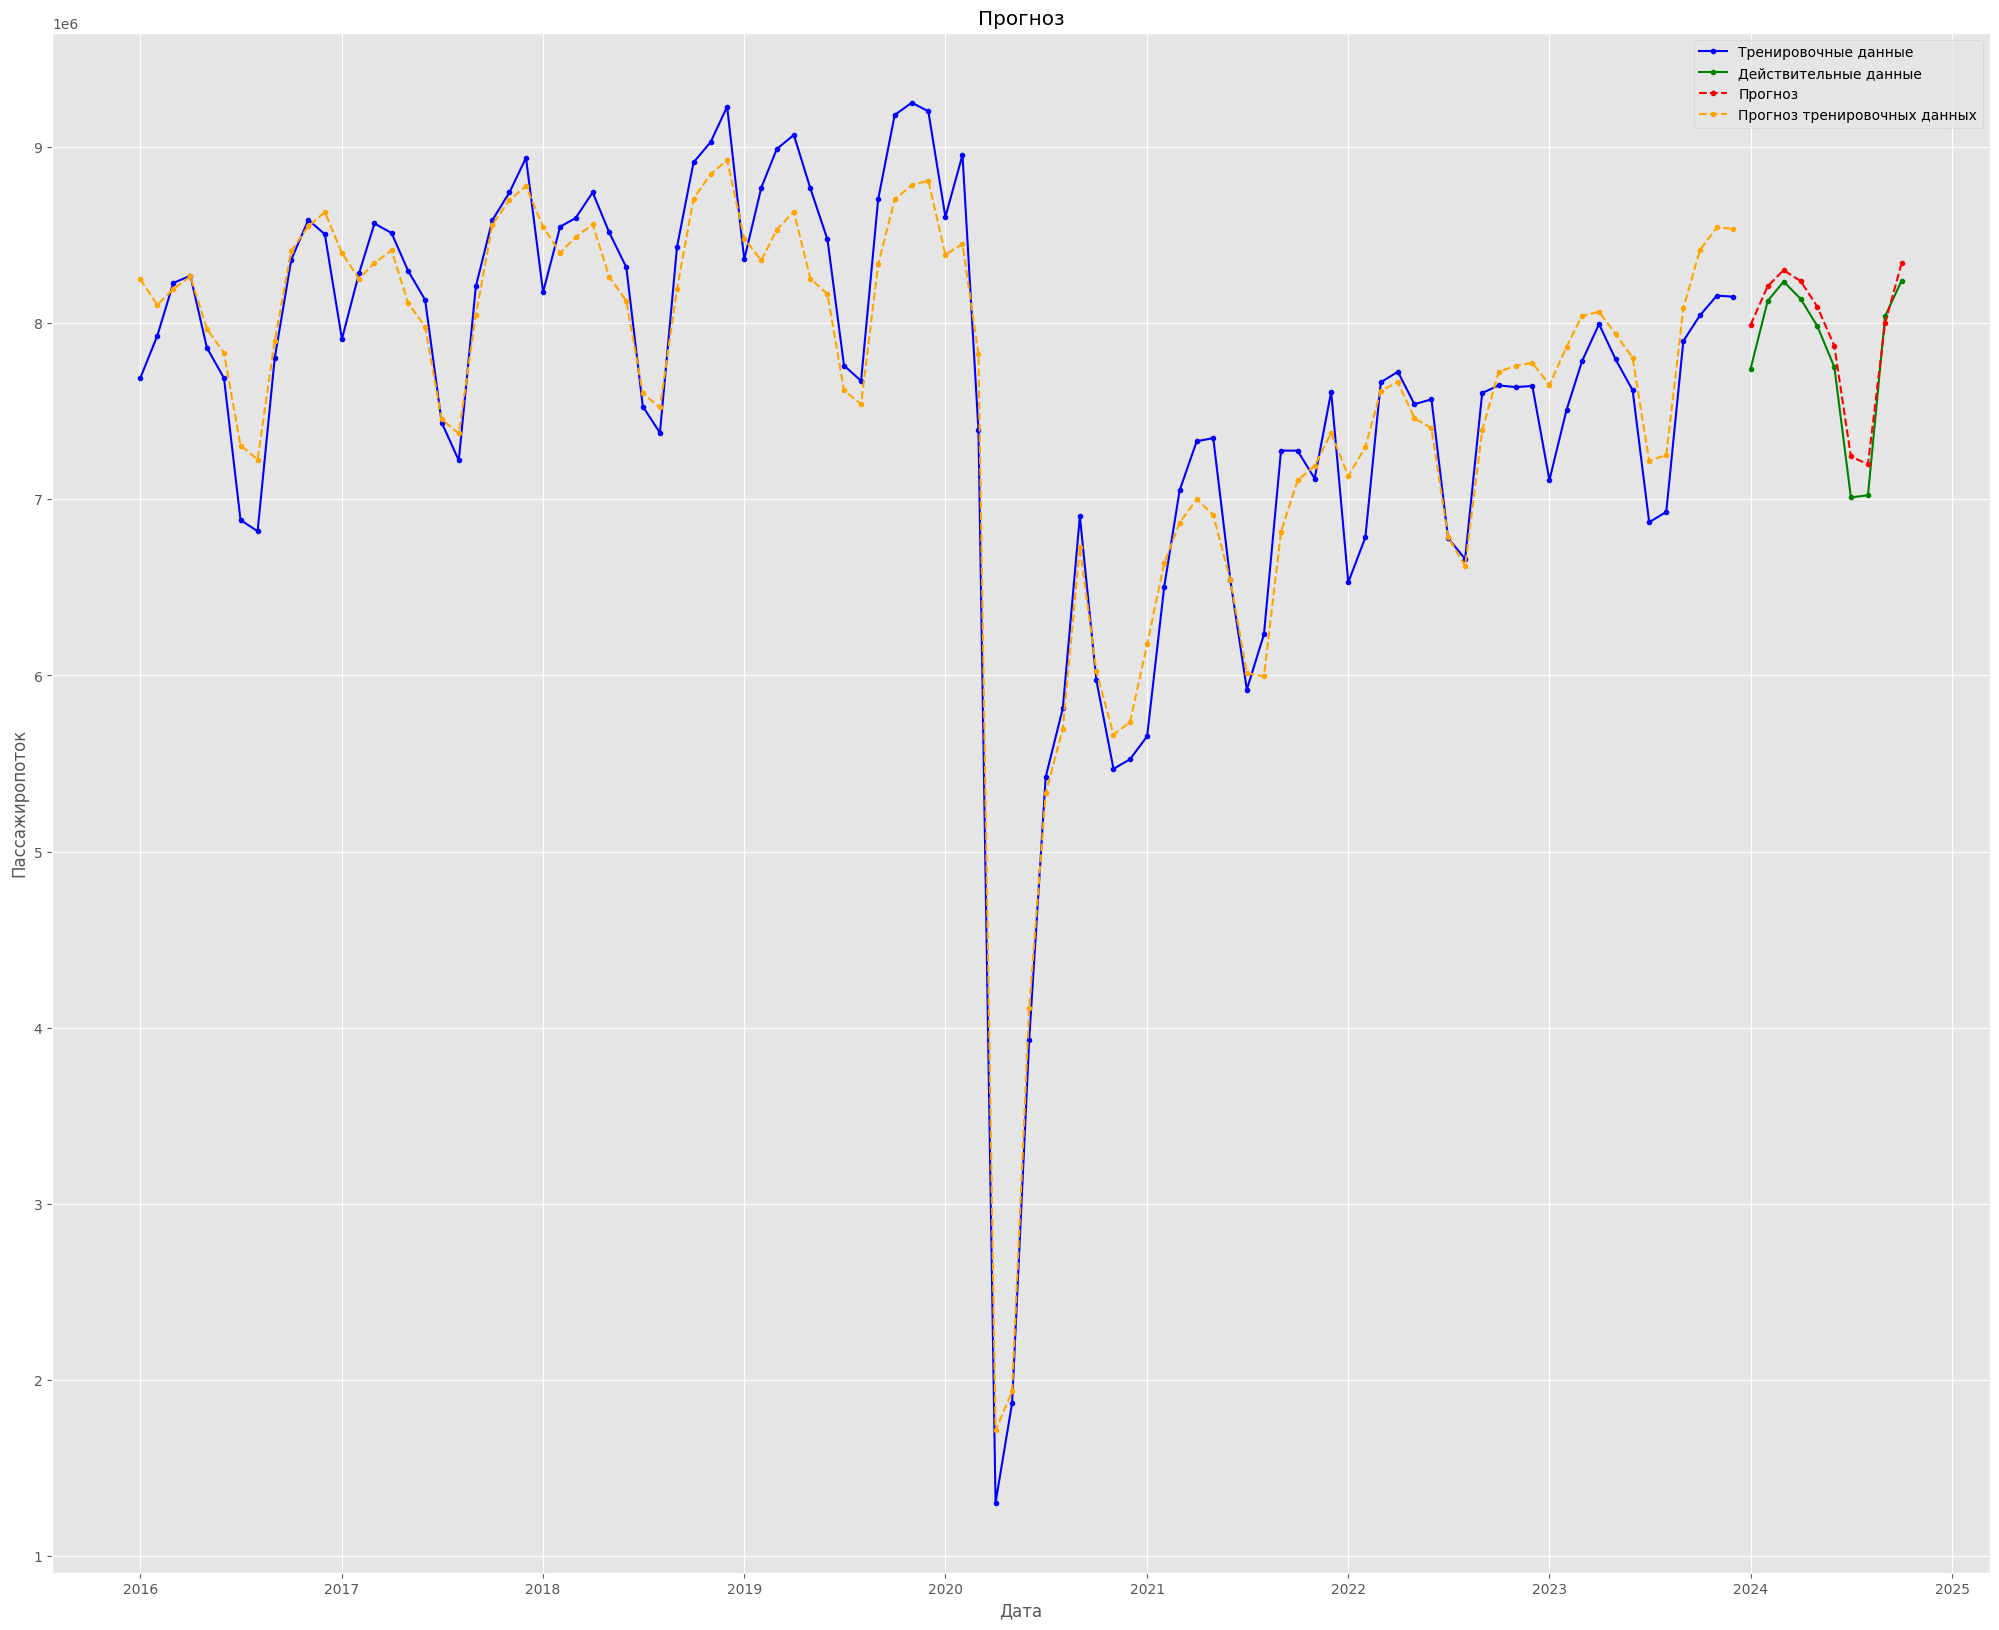

In [17]:
result_df = op_results['pred_df'].sort_index()
y_pred_train = result_df[result_df['test_data'] != 'X']['y_pred']
y_pred_test = result_df[result_df['test_data'] == 'X']['y_pred']

model_train.plot_ts_pred(y_train=y_train_test,
            y_pred_train=y_pred_train,
            y_test=y_test,
            y_pred_test=y_pred_test,
            show_all=True
            )

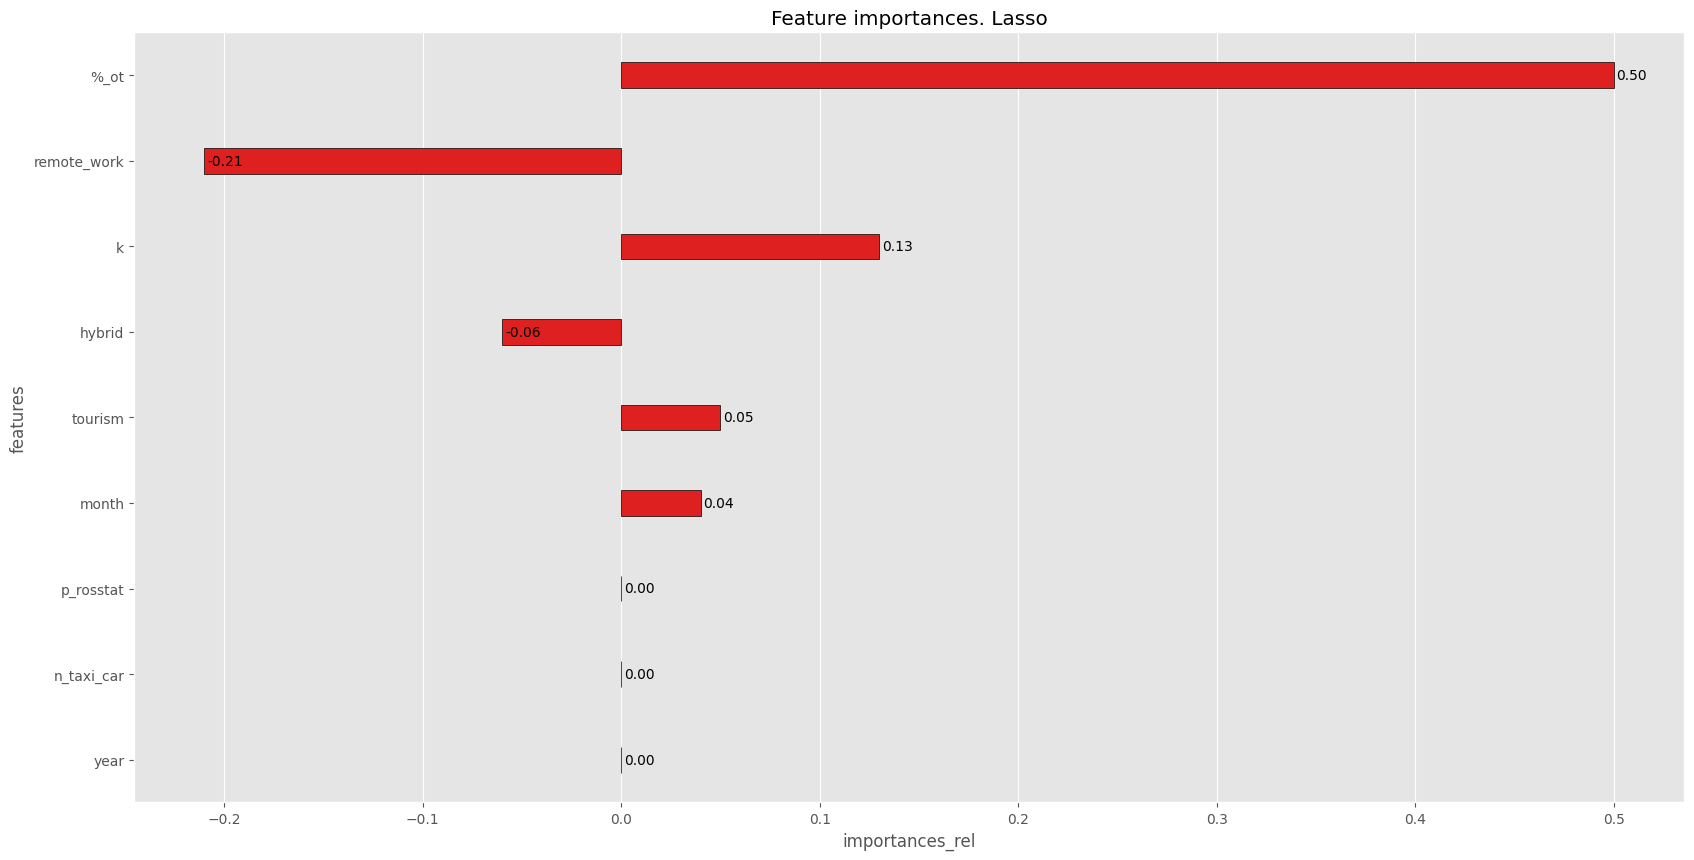

,features,importances,importances_rel
0,%_ot,791236.921,0.50
1,remote_work,-327173.608,-0.21
2,k,208580.661,0.13
3,hybrid,-100463.997,-0.06
4,tourism,80039.562,0.05
5,month,60247.615,0.04
6,p_rosstat,-2013.102,-0.00
7,n_taxi_сar,-0.000,-0.00
8,year,-0.000,-0.00


In [18]:
model_train.get_importances_barplot(X=X_train_std_1,
                                    model=op_results['model'],
                                    model_name="Lasso",
                                    show_shap=False)

___

## <center><a id=3 style='color:red'>Обучение Sarimax</a>

In [33]:
from typing import Literal


def train_arima(
    # Параметры auto_arima
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    start_p=0, max_p=3,     # Диапазон значений для параметра p
    start_d=0, max_d=3,     # Диапазон значений для параметра d
    start_q=0, max_q=3,     # Диапазон значений для параметра q
    start_P=0, max_P=3,     # Диапазон значений для параметра P (сезонная AR)
    start_D=0, max_D=3,     # Диапазон значений для параметра D (сезонная I)
    start_Q=0, max_Q=3,     # Диапазон значений для параметра Q (сезонная MA)
    d=None, D=None,         # Определяет порядок дифференцирования автоматически
    seasonal: bool=True,
    m=12,
    trend: Literal['c', 't', 'ct', 'n', 'ctt'] = None,
    with_intercept=True,
    trace=False,             # Показывать процесс подбора параметров
    error_action='ignore',  # Игнорировать ошибки при подборе
    suppress_warnings=True, # Подавить предупреждения
    stepwise=False,
    arima_params: dict = {},
    show_info: bool = True
    ) -> Dict[str, Any]:

    #----------------------------------------------------#
    # Обучение SARIMAX с подпором параметров
    #----------------------------------------------------#
    auto_model = auto_arima(
        y=y_train,
        X=X_train,
        seasonal=seasonal,
        m=m,
        start_p=start_p, max_p=max_p,     # Диапазон значений для параметра p
        start_q=start_q, max_q=max_q,     # Диапазон значений для параметра q
        start_P=start_P, max_P=max_P,     # Диапазон значений для параметра P (сезонная AR)
        start_Q=start_Q, max_Q=max_Q,     # Диапазон значений для параметра Q (сезонная MA)
        start_d=start_d, max_d=max_d,     # Диапазон значений для параметра Q (сезонная MA)
        start_D=start_D, max_D=max_D,     # Диапазон значений для параметра Q (сезонная MA)
        d=d, D=D,         # Определяет порядок дифференцирования автоматически
        trace=trace,             # Показывать процесс подбора параметров
        error_action=error_action,  # Игнорировать ошибки при подборе
        suppress_warnings=suppress_warnings, # Подавить предупреждения
        stepwise=stepwise,
        with_intercept=with_intercept,
        arima_params=arima_params
        )

    X_all = pd.concat([X_train, X_test]).drop_duplicates()
    y_all = pd.concat([y_train, y_test]).drop_duplicates()
    #----------------------------------------------------#
    # Получение метрик
    #----------------------------------------------------#
    train_metrics, y_pred_train = model_train.get_prediction(
                                X=X_train,
                                y=y_train[:],
                                model=auto_model,
                                sarimax_train=True,
                                metrics_type='train')
    test_metrics, y_pred_test = model_train.get_prediction(
                                X=X_test,
                                y=y_test,
                                model=auto_model,
                                sarimax_forecast=len(y_test),
                                metrics_type='test')

    auto_model_all = auto_arima(
        y=y_all,
        X=X_all,
        seasonal=seasonal,
        m=m,
        start_p=start_p, max_p=max_p,     # Диапазон значений для параметра p
        start_q=start_q, max_q=max_q,     # Диапазон значений для параметра q
        start_P=start_P, max_P=max_P,     # Диапазон значений для параметра P (сезонная AR)
        start_Q=start_Q, max_Q=max_Q,     # Диапазон значений для параметра Q (сезонная MA)
        start_d=start_d, max_d=max_d,     # Диапазон значений для параметра Q (сезонная MA)
        start_D=start_D, max_D=max_D,     # Диапазон значений для параметра Q (сезонная MA)
        d=d, D=D,         # Определяет порядок дифференцирования автоматически
        trace=trace,             # Показывать процесс подбора параметров
        error_action=error_action,  # Игнорировать ошибки при подборе
        suppress_warnings=suppress_warnings, # Подавить предупреждения
        stepwise=stepwise,
        with_intercept=with_intercept,
        arima_params=arima_params
        )
    all_metrics, y_pred_all = model_train.get_prediction(
                                X=X_all,
                                y=y_all[:],
                                model=auto_model_all,
                                sarimax_train=True,
                                metrics_type='test_all')

    y_pred_all.name = 'y_pred'
    y_all.name = 'y_true'

    pred_df = pd.concat([X_all , y_all, y_pred_all], axis=1)
    pred_df.drop_duplicates(inplace=True)
    pred_df['abs_error'] = pred_df['y_pred'] - pred_df['y_true']
    pred_df['rel_error'] = round(abs(pred_df['abs_error'] / pred_df['y_true']), 3) * 100
    pred_df['test_data'] = " "
    pred_df.loc[y_test.index, 'test_data'] = "X"

    train_results = {}
    train_results['model'] = auto_model
    train_results['train_metrics'] = train_metrics
    train_results['test_metrics'] = test_metrics
    train_results['all_metrics'] = all_metrics
    train_results['pred_df'] = pred_df

    #----------------------------------------------------#
    # Визуализация данных
    #----------------------------------------------------#
    if show_info:
        print(auto_model.summary())
        diagnostic_plot = auto_model.plot_diagnostics(figsize=(10, 10))
        model_train.plot_ts_pred(
            y_train=y_train,
            y_pred_train=y_pred_train,
            y_test=y_test,
            y_pred_test=y_pred_test,
            show_all=True
        )
    return train_results

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1302.309
Date:                             Thu, 30 Jan 2025   AIC                           2632.618
Time:                                     20:05:40   BIC                           2668.519
Sample:                                 01-01-2016   HQIC                          2647.130
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    2.822e+06   3298.022    855.669      0.000    2.82e+06    2.83e+06
year         2.046e+05  

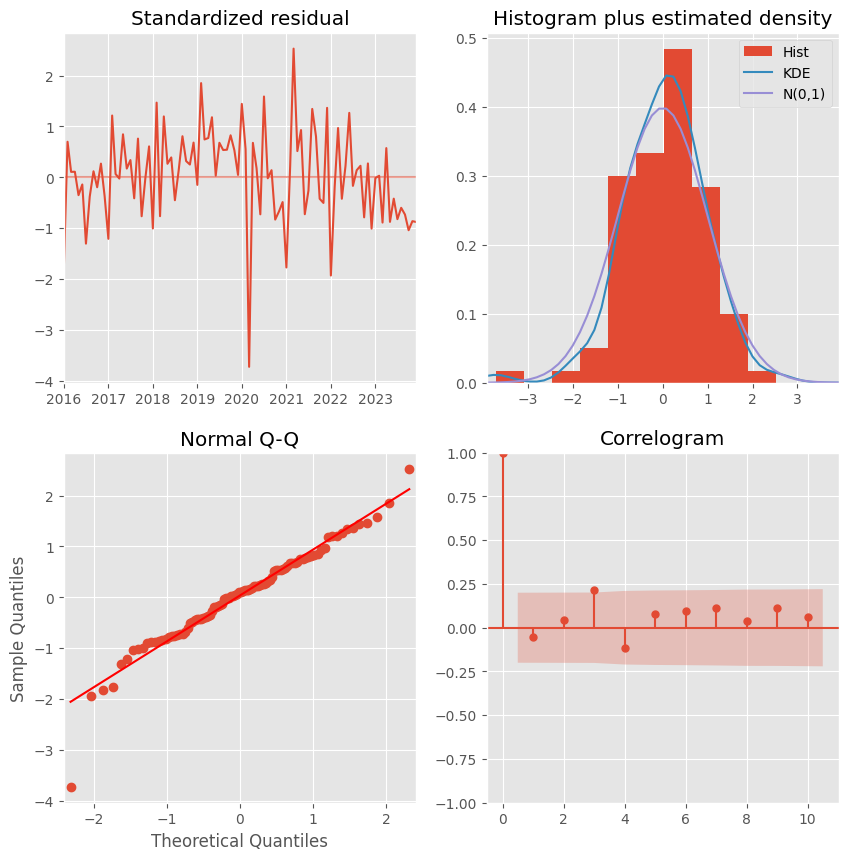

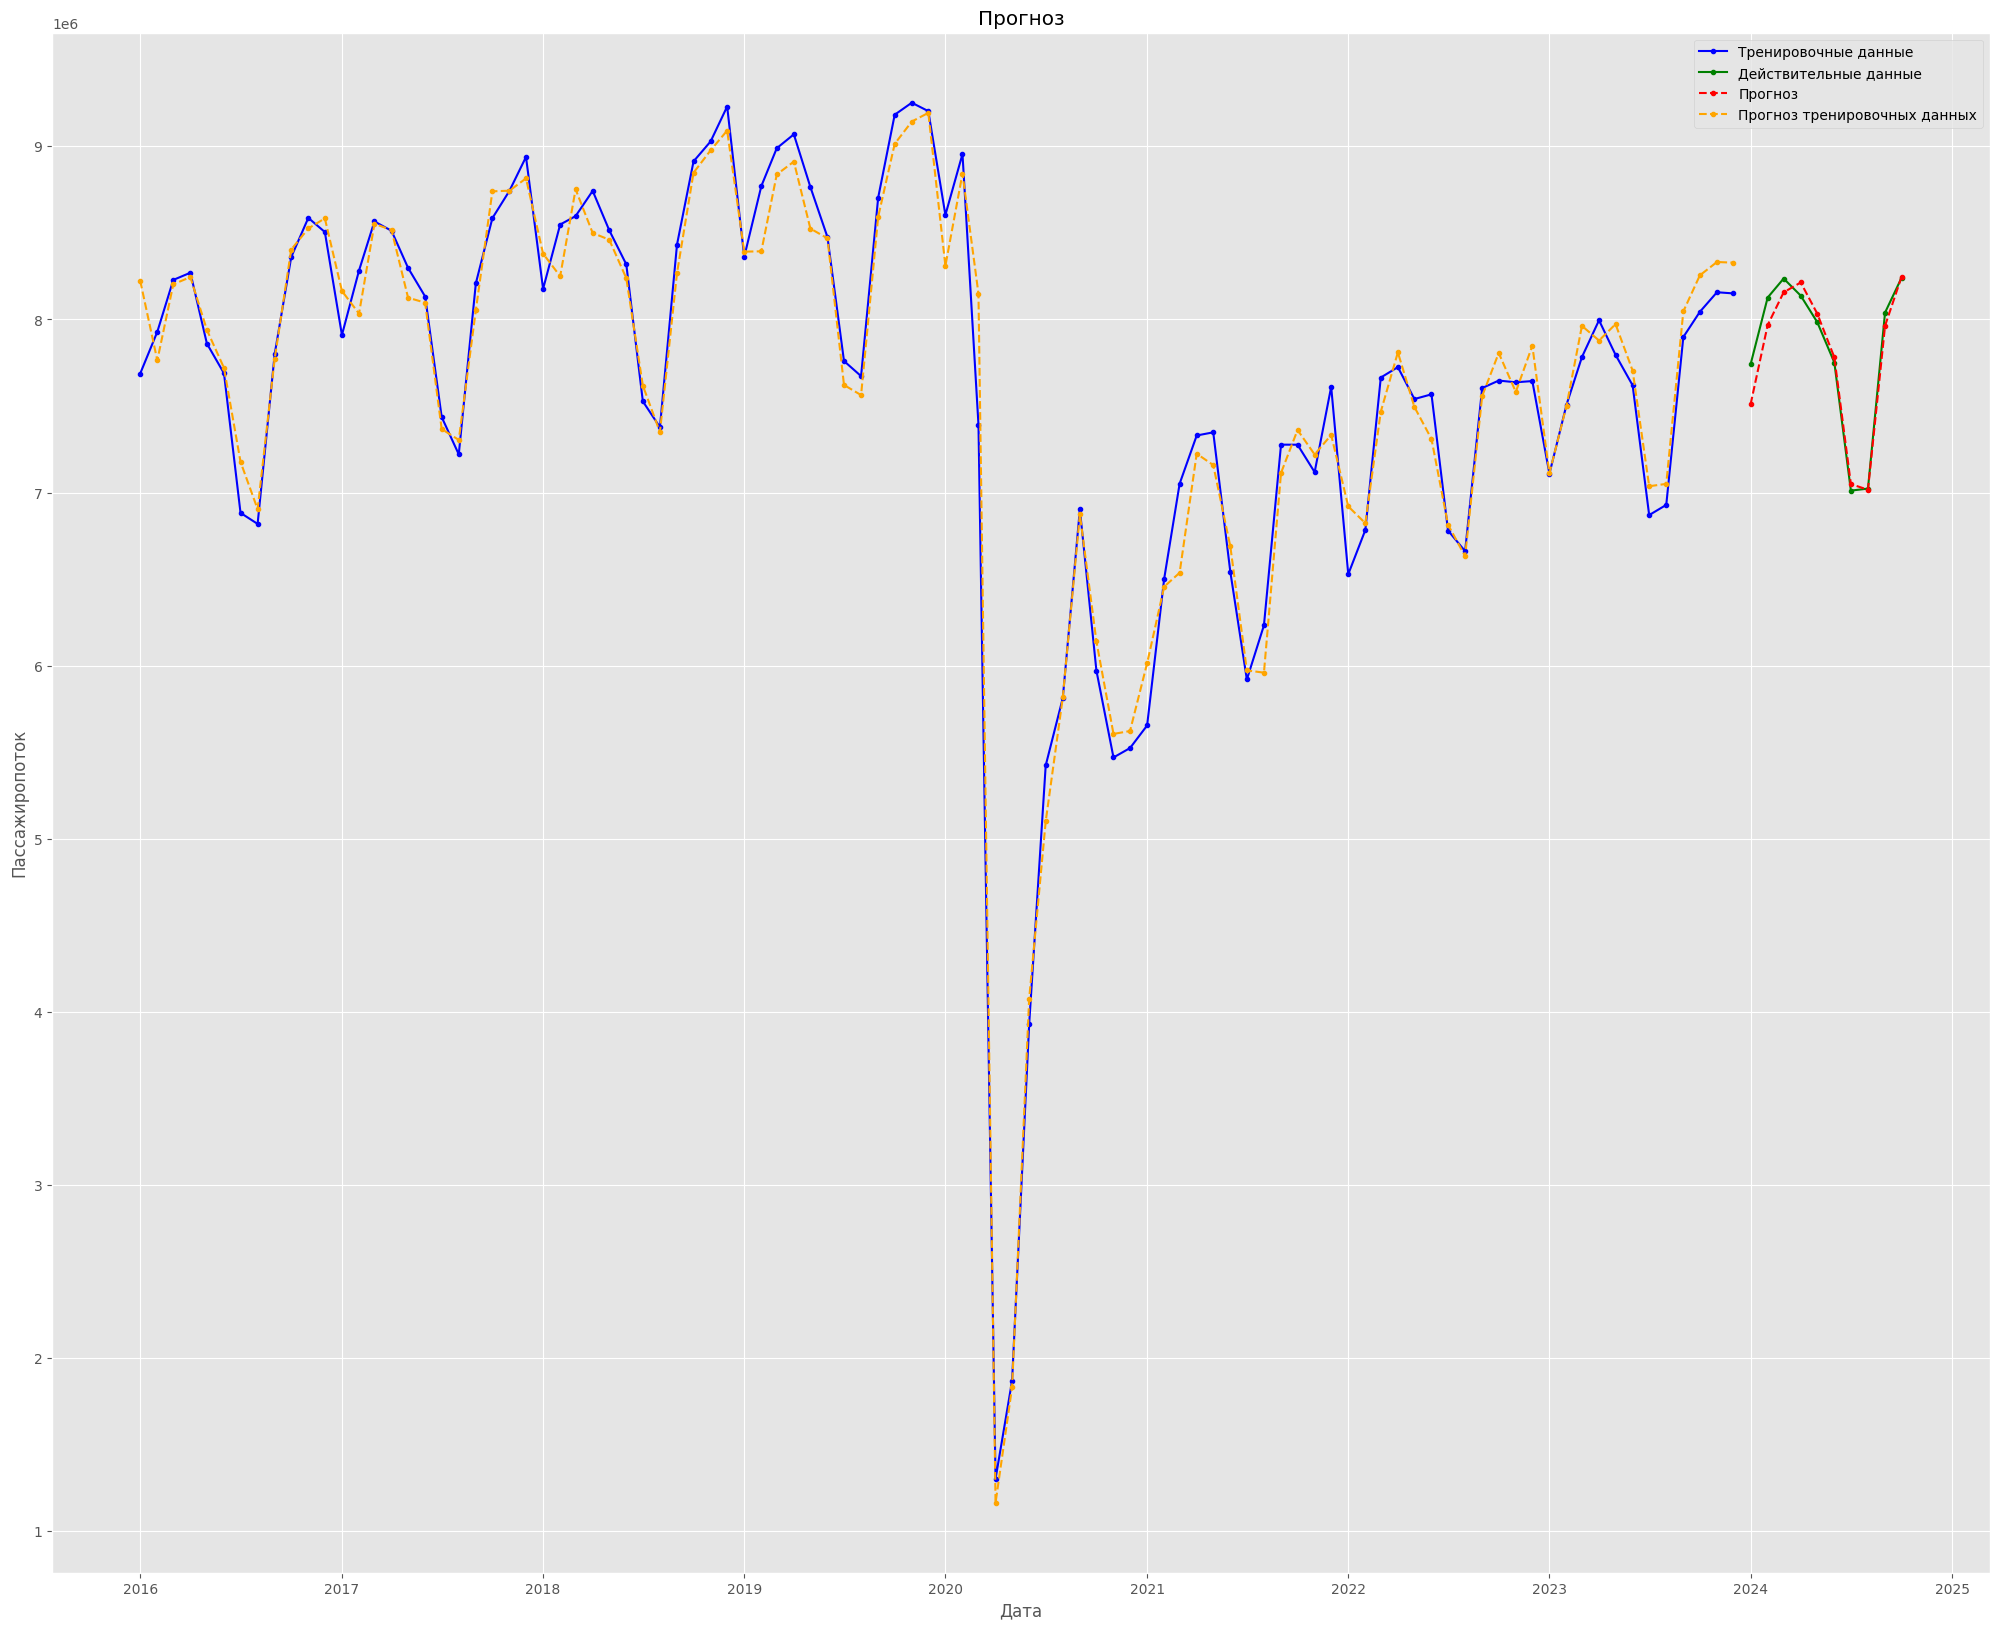

In [38]:
arima_results = train_arima(
    X_train=X_train_test_std_1,
    y_train=y_train_test,
    X_test=X_test_std_1,
    y_test=y_test,
    start_p=0, max_p=3,     # Диапазон значений для параметра p
    start_d=0, max_d=3,     # Диапазон значений для параметра d
    start_q=0, max_q=3,     # Диапазон значений для параметра q
    start_P=0, max_P=3,     # Диапазон значений для параметра P (сезонная AR)
    start_D=0, max_D=3,     # Диапазон значений для параметра D (сезонная I)
    start_Q=0, max_Q=3,     # Диапазон значений для параметра Q (сезонная MA)
    arima_params={"maxiter": "100"},
    show_info=True,
    with_intercept=True
)

In [39]:
display(arima_results['train_metrics'])
display(arima_results['test_metrics'])
display(arima_results['all_metrics'])


,model_train,negative_train,RE_train,MAE_train,RMSE_train,NRMSE_train,R2_train,data
0,"ARIMA(1,0,1)(1,0,0)[12] intercept",0,1.0,141913.459755,188682.647714,0.023739,0.97962,data_name


,model_test,negative_test,RE_test,MAE_test,RMSE_test,NRMSE_test,R2_test,data
0,"ARIMA(1,0,1)(1,0,0)[12] intercept",0,1.0,75129.431691,100659.889411,0.081863,0.947221,data_name


,model_test_all,negative_test_all,RE_test_all,MAE_test_all,RMSE_test_all,NRMSE_test_all,R2_test_all,data
0,"ARIMA(3,0,0)(2,0,0)[12] intercept",0,0.971698,439903.382577,695258.186794,0.087473,0.698905,data_name


In [40]:
arima_results['pred_df'].sort_values(by='rel_error', ascending=False)

,year,month,%_ot,n_taxi_сar,p_rosstat,k,remote_work,hybrid,tourism,y_true,y_pred,abs_error,rel_error,test_data
date,,,,,,,,,,,,,,
2021-01-01,0.654654,-1.593255,-1.044763,0.540030,0.105372,-0.510300,0.463813,1.284352,-1.168559,5654414,9.155996e+06,3.501582e+06,61.9,
2020-05-01,0.218218,-0.434524,-4.795381,-1.863014,0.180231,0.063673,4.797913,0.573603,-2.613723,1869126,1.173881e+06,-6.952454e+05,37.2,
2024-01-01,1.963961,-1.593255,0.593451,0.787119,1.716462,-0.510300,-0.402061,0.483366,0.793919,7740192,1.012549e+07,2.385302e+06,30.8,X
2017-01-01,-1.091089,-1.593255,1.077114,-1.088227,-1.281142,-0.510300,-0.542917,-0.893135,-1.279087,7909739,1.014854e+07,2.238802e+06,28.3,
2020-06-01,0.218218,-0.144841,-2.786173,-0.545983,0.180231,-0.278746,2.634780,1.284352,-2.580739,3928961,2.953642e+06,-9.753194e+05,24.8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-01,-1.527525,-0.144841,-0.002112,-0.906241,-1.443878,-0.278746,-0.542917,-0.893135,0.611266,7688398,7.690377e+06,1.979083e+03,0.0,
2019-11-01,-0.218218,1.303572,0.722789,-0.607308,-0.024817,1.149536,-0.542917,-0.893135,0.579884,9251542,9.248534e+06,-3.007803e+03,0.0,
2022-08-01,1.091089,0.434524,-0.312267,1.119599,1.277074,-2.024222,0.463813,1.284352,-0.413188,6661210,6.663003e+06,1.792785e+03,0.0,


___

## <center><a id=3 style='color:red'>Обучение Lasso</a>

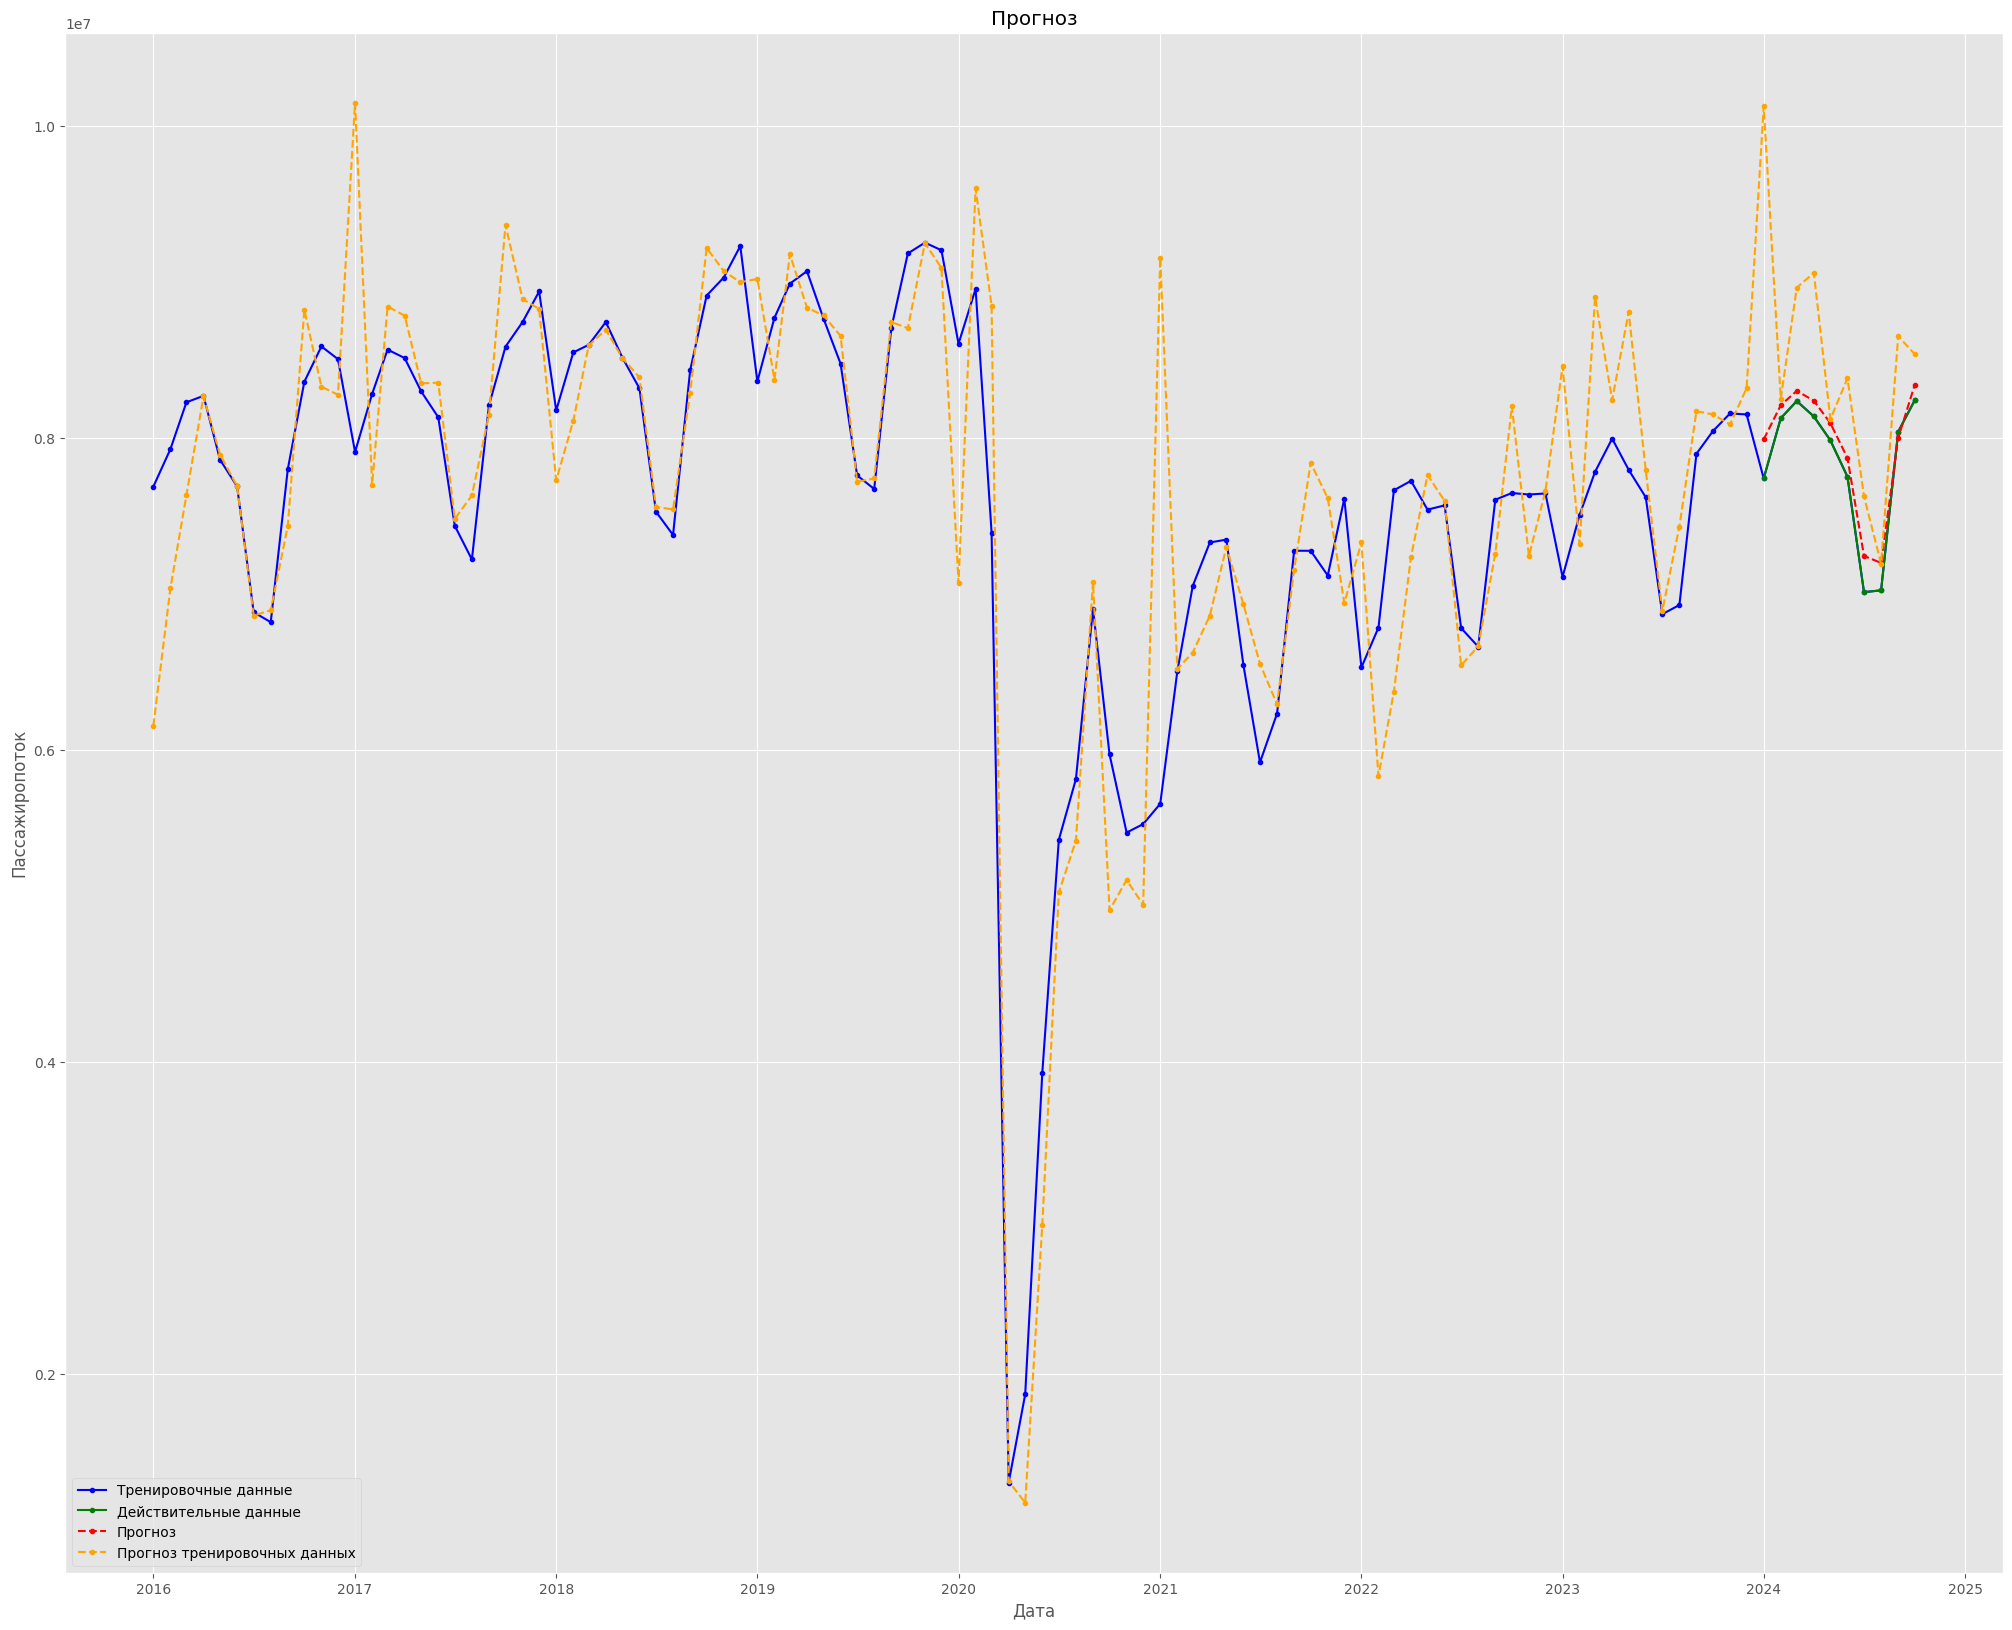

In [41]:
model_train.plot_ts_pred(y_train=arima_results['pred_df']['y_true'],
            y_pred_train=arima_results['pred_df']['y_pred'],
            y_test=y_test,
            y_pred_test=y_pred_test,
            show_all=True
            )


In [91]:
X_all.shape, y_all.shape

((106, 9), (106,))

In [92]:
m = arima_results['model']
best_params = m.get_params()

mm = auto_arima(y=y_all, X=X_all, **best_params)

In [ ]:
all_metrics, y_pred_all = model_train.get_prediction(
                            X=X_all,
                            y=y_all[1:],
                            model=mm,
                            sarimax_train=True,
                            metrics_type='test_all')

In [101]:
y_pred_all

date
2016-02-01    7.057205e+06
2016-03-01    7.569425e+06
2016-04-01    8.286803e+06
2016-05-01    7.999679e+06
2016-06-01    7.747399e+06
                  ...     
2024-06-01    7.993602e+06
2024-07-01    7.289167e+06
2024-08-01    6.995206e+06
2024-09-01    8.181772e+06
2024-10-01    8.461884e+06
Freq: MS, Length: 105, dtype: float64